<a href="https://colab.research.google.com/github/mirdanish6594/Vision-Transformer/blob/main/Vision_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow==2.8.0
!pip install keras==2.8.0
!pip install tensorflow-addons==0.17.0 #(0.20.0)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 497.6/497.6 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.5/462.5 kB 26.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 47.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 62.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 66.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 29.1 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.7.2
    Uninstalling tensorboard-data-server-0.7.2:
      Successfully uninstalled tensorboard-data-server-0.7.2
  Attempting uninstall: google-auth-oauthlib
    Found existing installation: goo

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

In [3]:
num_classes = 10
input_shape = (32, 32, 3)
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

170508288/170498071 [==============================] - 10s 0us/step
x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)


In [13]:
x_train = x_train[:500]
y_train = y_train[:500]
x_test = x_test[:500]
y_test = y_test[:500]

In [4]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 40
image_size = 72 # we'll resize input images to this size
patch_size = 6 # size of the patches to be extracted from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim*2,
    projection_dim
] # size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024] # size of the dense layers of the final classifier

In [5]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor = 0.02),
        layers.RandomZoom(height_factor = 0.2, width_factor = 0.2)
    ],
    name = "data_augmentation"
)
data_augmentation.layers[0].adapt(x_train)

In [6]:
def mlp(x, hidden_units, dropout_rate):
  for units in hidden_units:
    x = layers.Dense(units, activation = tf.nn.gelu)(x)
    x = layers.Dropout(dropout_rate)(x)
  return x

In [7]:
class Patches(layers.Layer):
  def __init__(self, patch_size):
    super(Patches, self).__init__()
    self.patch_size = patch_size

  def call(self, images):
    batch_size = tf.shape(images)[0]
    patches = tf.image.extract_patches(
        images = images,
        sizes = [1, self.patch_size, self.patch_size, 1],
        strides = [1, self.patch_size, self.patch_size, 1],
        rates = [1, 1, 1, 1],
        padding = "VALID",
    )
    patch_dims = patches.shape[-1]
    patches = tf.reshape(patches, [batch_size, -1, patch_dims])
    return patches

Image size: 72 X 72
Patch size: 6 X 6
Pathes per image: 144
Elements per patch: 108


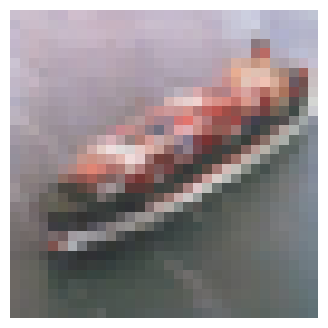

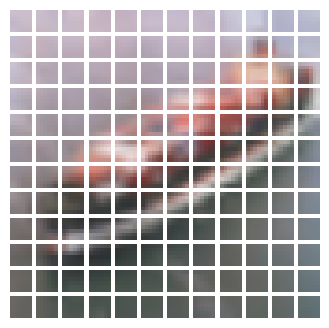

In [8]:
import matplotlib.pyplot as plt
plt.figure(figsize = (4,4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size = (image_size, image_size)
)

patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Pathes per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize = (4,4))
for i, patch in enumerate(patches[0]):
  ax = plt.subplot(n, n, i+1)
  patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
  plt.imshow(patch_img.numpy().astype("uint8"))
  plt.axis("off")

In [9]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = tf.keras.layers.Dense(units=projection_dim)
        self.position_embedding = tf.keras.layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patches):
        print(f"Patch shape before projection: {patches.shape}")
        encoded = self.projection(patches)
        print(f"Patch shape after projection: {encoded.shape}")
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded += self.position_embedding(positions)
        return encoded

In [10]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    augmented = data_augmentation(inputs)
    patches = Patches(patch_size)(augmented)
    print(f"Patch shape before projection: {patches.shape}")
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)
    print(f"Patch shape after projection: {encoded_patches.shape}")

    # Transformer block
    for _ in range(transformer_layers):
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        x2 = layers.Add()([attention_output, encoded_patches])
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        encoded_patches = layers.Add()([x3, x2])

    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    logits = layers.Dense(num_classes)(features)
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [11]:
def run_experiment(model):
  optimizer = tfa.optimizers.AdamW(
      learning_rate = learning_rate, weight_decay = weight_decay
  )

  model.compile(
      optimizer = optimizer,
      loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
      metrics = [
          keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
          keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
      ],
  )
  checkpoint_filepath = "./temp/checkpoint"
  checkpoint_callback = keras.callbacks.ModelCheckpoint(
      checkpoint_filepath,
      monitor = "val_accuracy",
      save_best_only = True,
      save_weights_only = True
  )
  history = model.fit(
      x = x_train,
      y = y_train,
      batch_size = batch_size,
      epochs = num_epochs,
      validation_split = 0.1,
      callbacks = [checkpoint_callback],
  )

  model.load_weights(checkpoint_filepath)
  _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
  print(f"Test accuracy: {round(accuracy*100, 2)}%")
  print(f"Test top 5 accuracy: {round(top_5_accuracy*100, 2)}%")

In [14]:
vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)

Patch shape before projection: (None, None, 108)
Patch shape before projection: (None, None, 108)
Patch shape after projection: (None, None, 64)
Patch shape after projection: (None, 144, 64)
Epoch 1/40
Patch shape before projection: (None, None, 108)
Patch shape after projection: (None, None, 64)
Patch shape before projection: (None, None, 108)
Patch shape after projection: (None, None, 64)
2/2 [==============================] - ETA: 0s - loss: 6.4856 - accuracy: 0.1244 - top-5-accuracy: 0.5244 Patch shape before projection: (None, None, 108)
Patch shape after projection: (None, None, 64)
2/2 [==============================] - 57s 20s/step - loss: 6.4856 - accuracy: 0.1244 - top-5-accuracy: 0.5244 - val_loss: 4.7268 - val_accuracy: 0.1800 - val_top-5-accuracy: 0.6400
Epoch 2/40
2/2 [==============================] - 34s 15s/step - loss: 5.9839 - accuracy: 0.2022 - top-5-accuracy: 0.5822 - val_loss: 2.7036 - val_accuracy: 0.2200 - val_top-5-accuracy: 0.6800
Epoch 3/40
2/2 [=============